In [1]:
from src.utils.image_utils import get_annotated_image

import cv2

image_bgr = cv2.imread('dataset/sequences/00/image_2/000020.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

res = get_annotated_image(image_rgb)  # original image with masks applied to it

In [17]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

from src.constants import CHECKPOINT_PATH
from src.constants import DEVICE
from src.constants import MODEL_TYPE

def get_array_instances_by_image_sam(cam_image):
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

    mask_generator = SamAutomaticMaskGenerator(sam)

    return mask_generator.generate(cam_image)

In [40]:
arr_sam = get_array_instances_by_image_sam(cv2.imread('images_cams/images/00000000.jpg'))  # an array of masks, each in the form of a dictionary

In [41]:
import numpy as np
import supervision as sv

from PIL import Image as im

def get_annotated_image(cam_image, sam_result):
    mask_annotator = sv.MaskAnnotator(opacity = 1.0, color_lookup = sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=sam_result)

    black_image = get_black_image(cam_image)

    annotated_image = mask_annotator.annotate(
        scene=np.array(black_image), detections=detections
    )

    return im.fromarray(annotated_image)


def get_black_image(src_image):
    black_image = im.fromarray(src_image)
    black_pixels = black_image.load()
    for x in range(black_image.width):
        for y in range(black_image.height):
            black_pixels[x, y] = (0, 0, 0)

    return black_image

In [42]:
res2 = get_annotated_image(cv2.imread('images_cams/images/00000000.jpg'), arr_sam)  # original image with masks 'arr_sam' applied to it

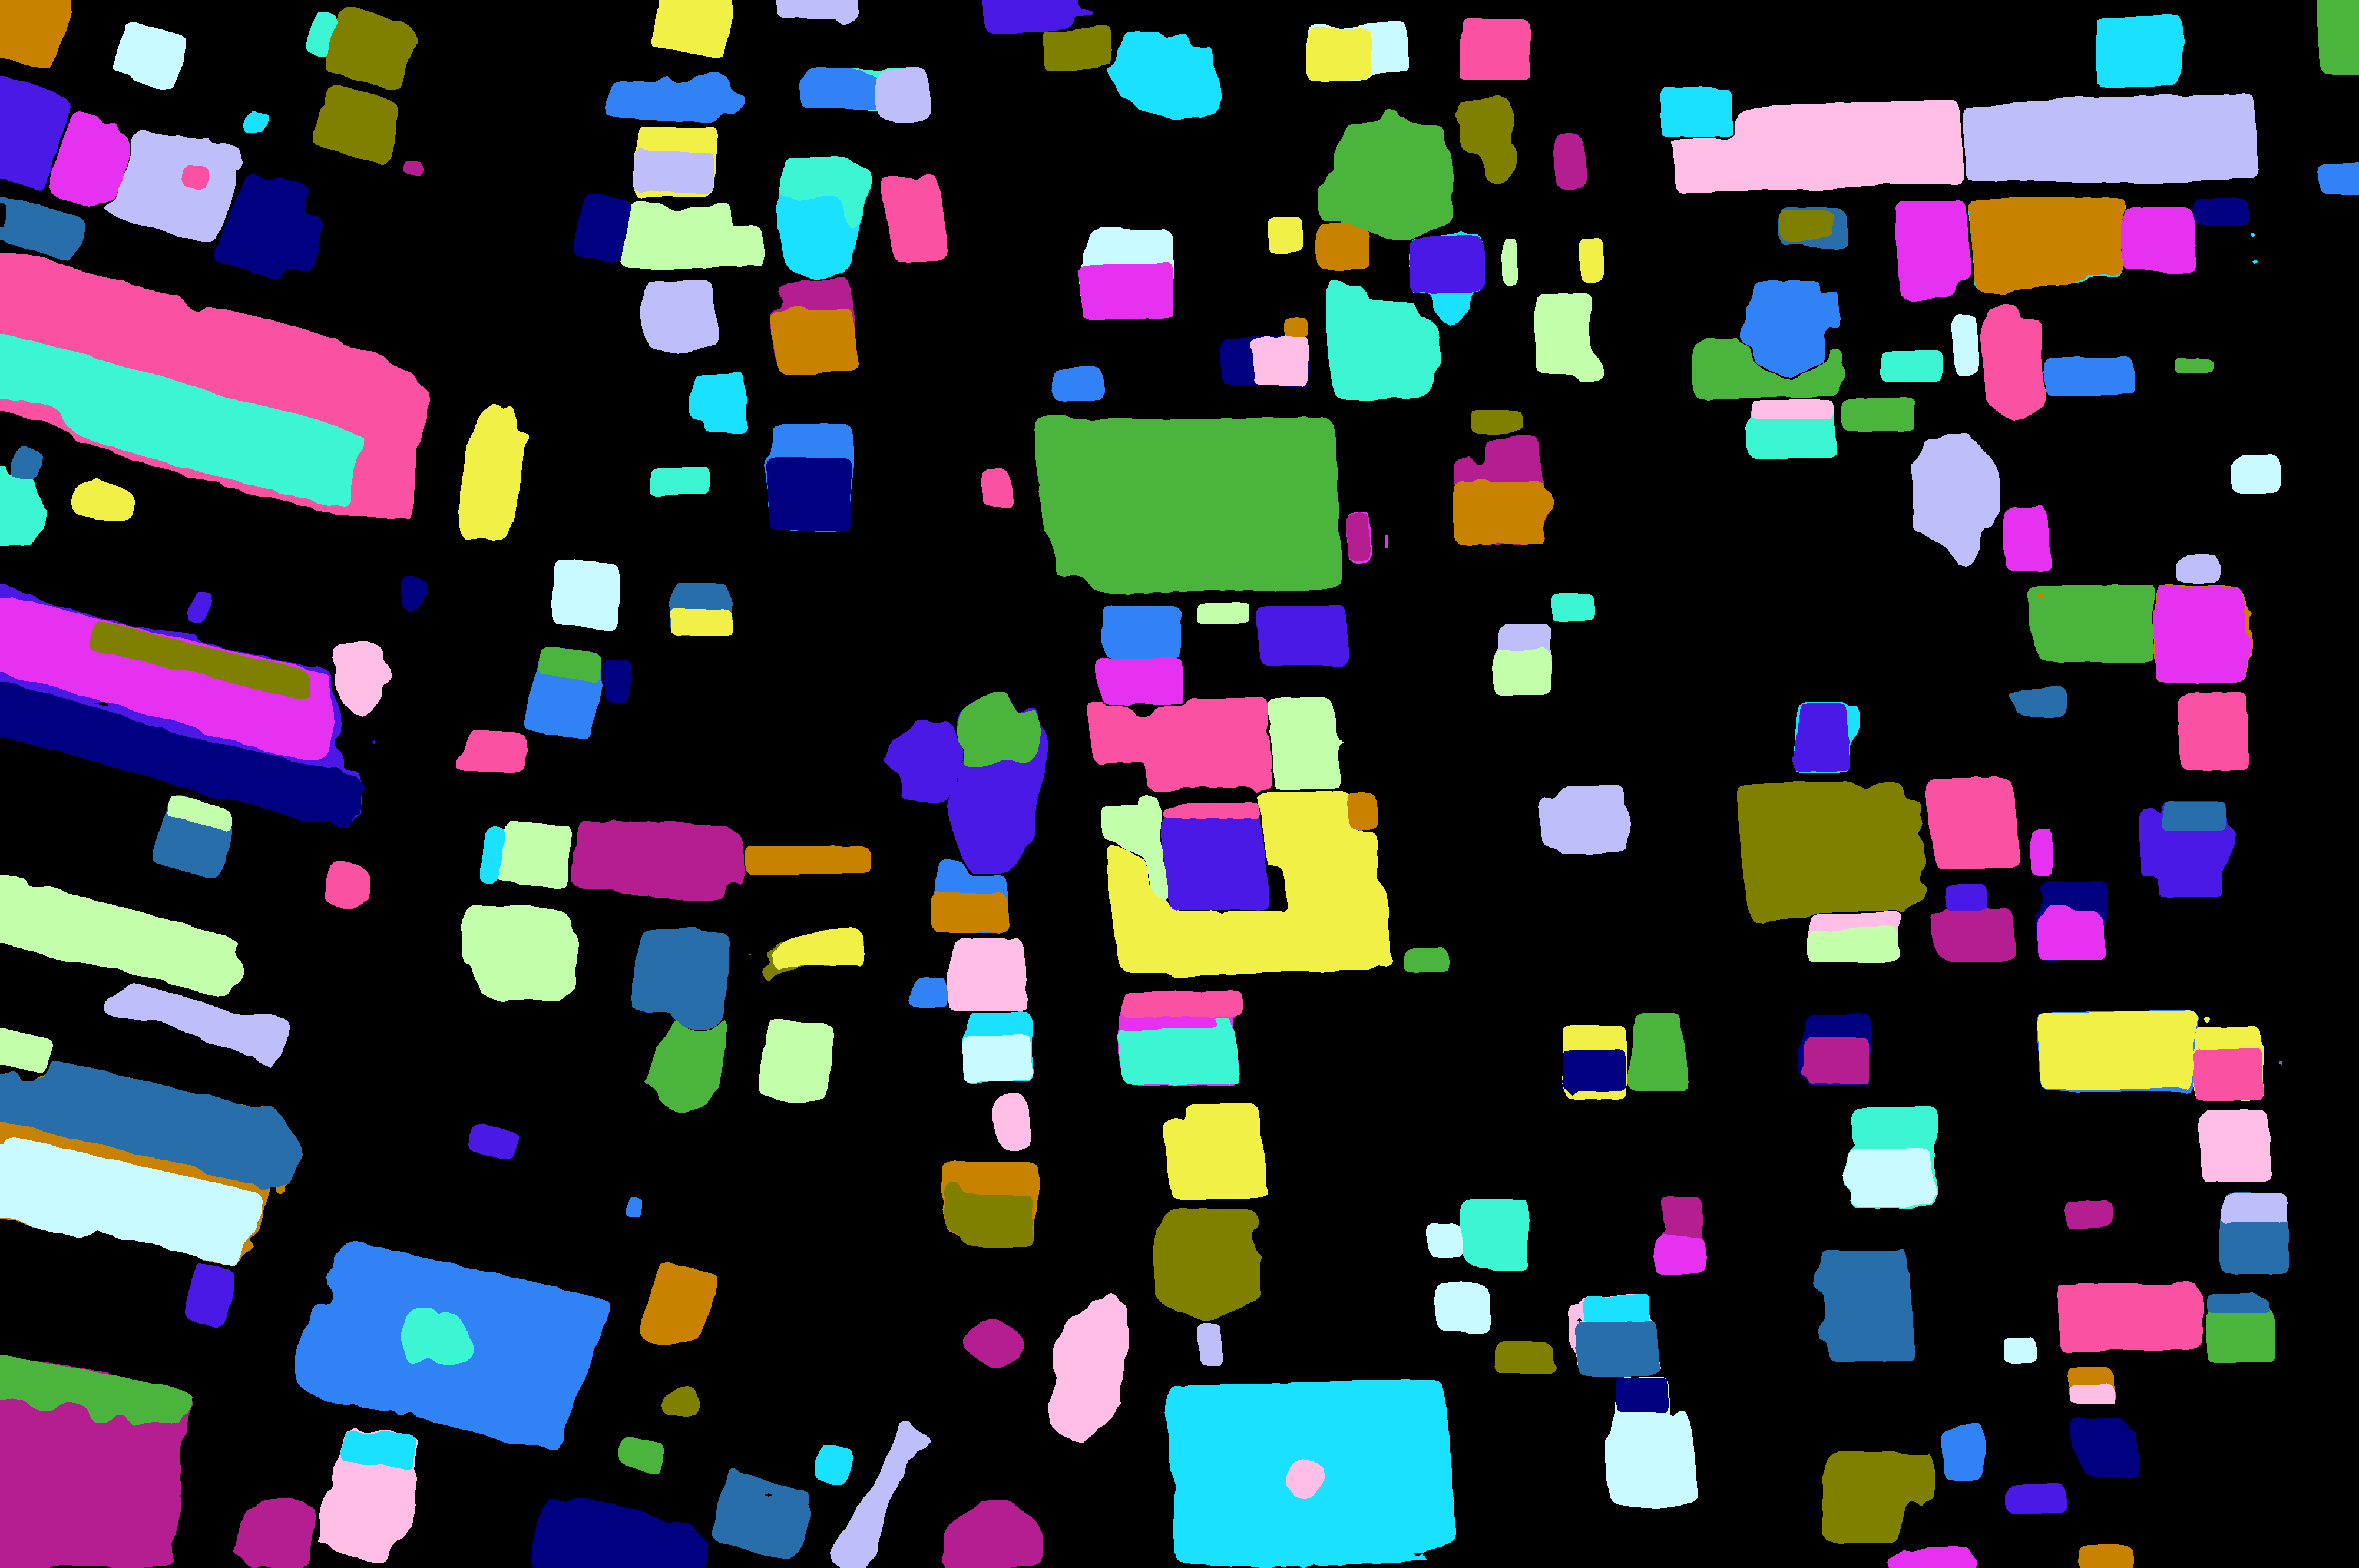

In [43]:
res2  # visualization

In [44]:
from src.utils.geometry_utils import calculate_area
from src.utils.sam_mask_utils import find_intersection_mask
from src.utils.sam_mask_utils import find_union_mask

def reduce_detail(
    masks,
    int_to_union_threshold,
    int_to_mask_threshold,
):
    merged_mask = []
    merged_indices = []  # indices in the original masks that were merged

    for i in range(len(masks)):
        if i in merged_indices:
            continue

        area_bbox_i = calculate_area(masks[i]["bbox"])

        indices_merged_with_i = []
        for j in range(i + 1, len(masks)):
            if j in merged_indices:
                continue

            area_bbox_j = calculate_area(masks[j]["bbox"])

            intersection_mask = find_intersection_mask(masks[i], masks[j])
            if intersection_mask == None:
                continue
            area_intersection = intersection_mask["area"]

            area_bbox_intersection = calculate_area(intersection_mask["bbox"])
            area_bbox_union = area_bbox_i + area_bbox_j - area_bbox_intersection
            IU_ratio = area_bbox_intersection / area_bbox_union

            if (
                IU_ratio >= int_to_union_threshold
                or area_intersection / masks[i]["area"] >= int_to_mask_threshold
                or area_intersection / masks[j]["area"] >= int_to_mask_threshold
            ):
                masks[i] = find_union_mask(masks[i], masks[j])
                indices_merged_with_i.append(j)

        if indices_merged_with_i:
            # the final result of the union is extracted from the masks[i]
            merged_mask.append(masks[i])

            merged_indices.append(i)
            for ind in indices_merged_with_i:
                merged_indices.append(ind)

    masks_result = []
    for ind, mask in enumerate(masks):
        if ind not in merged_indices:
            masks_result.append(mask)  # save it unchanged

    for mask in merged_mask:
        masks_result.append(mask)

    return masks_result

In [45]:
new_masks = reduce_detail(arr_sam, 0.5, 0.5)  # the same masks arr_sam, but some of them are merged

In [46]:
res3 = get_annotated_image(cv2.imread('images_cams/images/00000000.jpg'), new_masks)  # original image with masks 'new_masks' applied to it

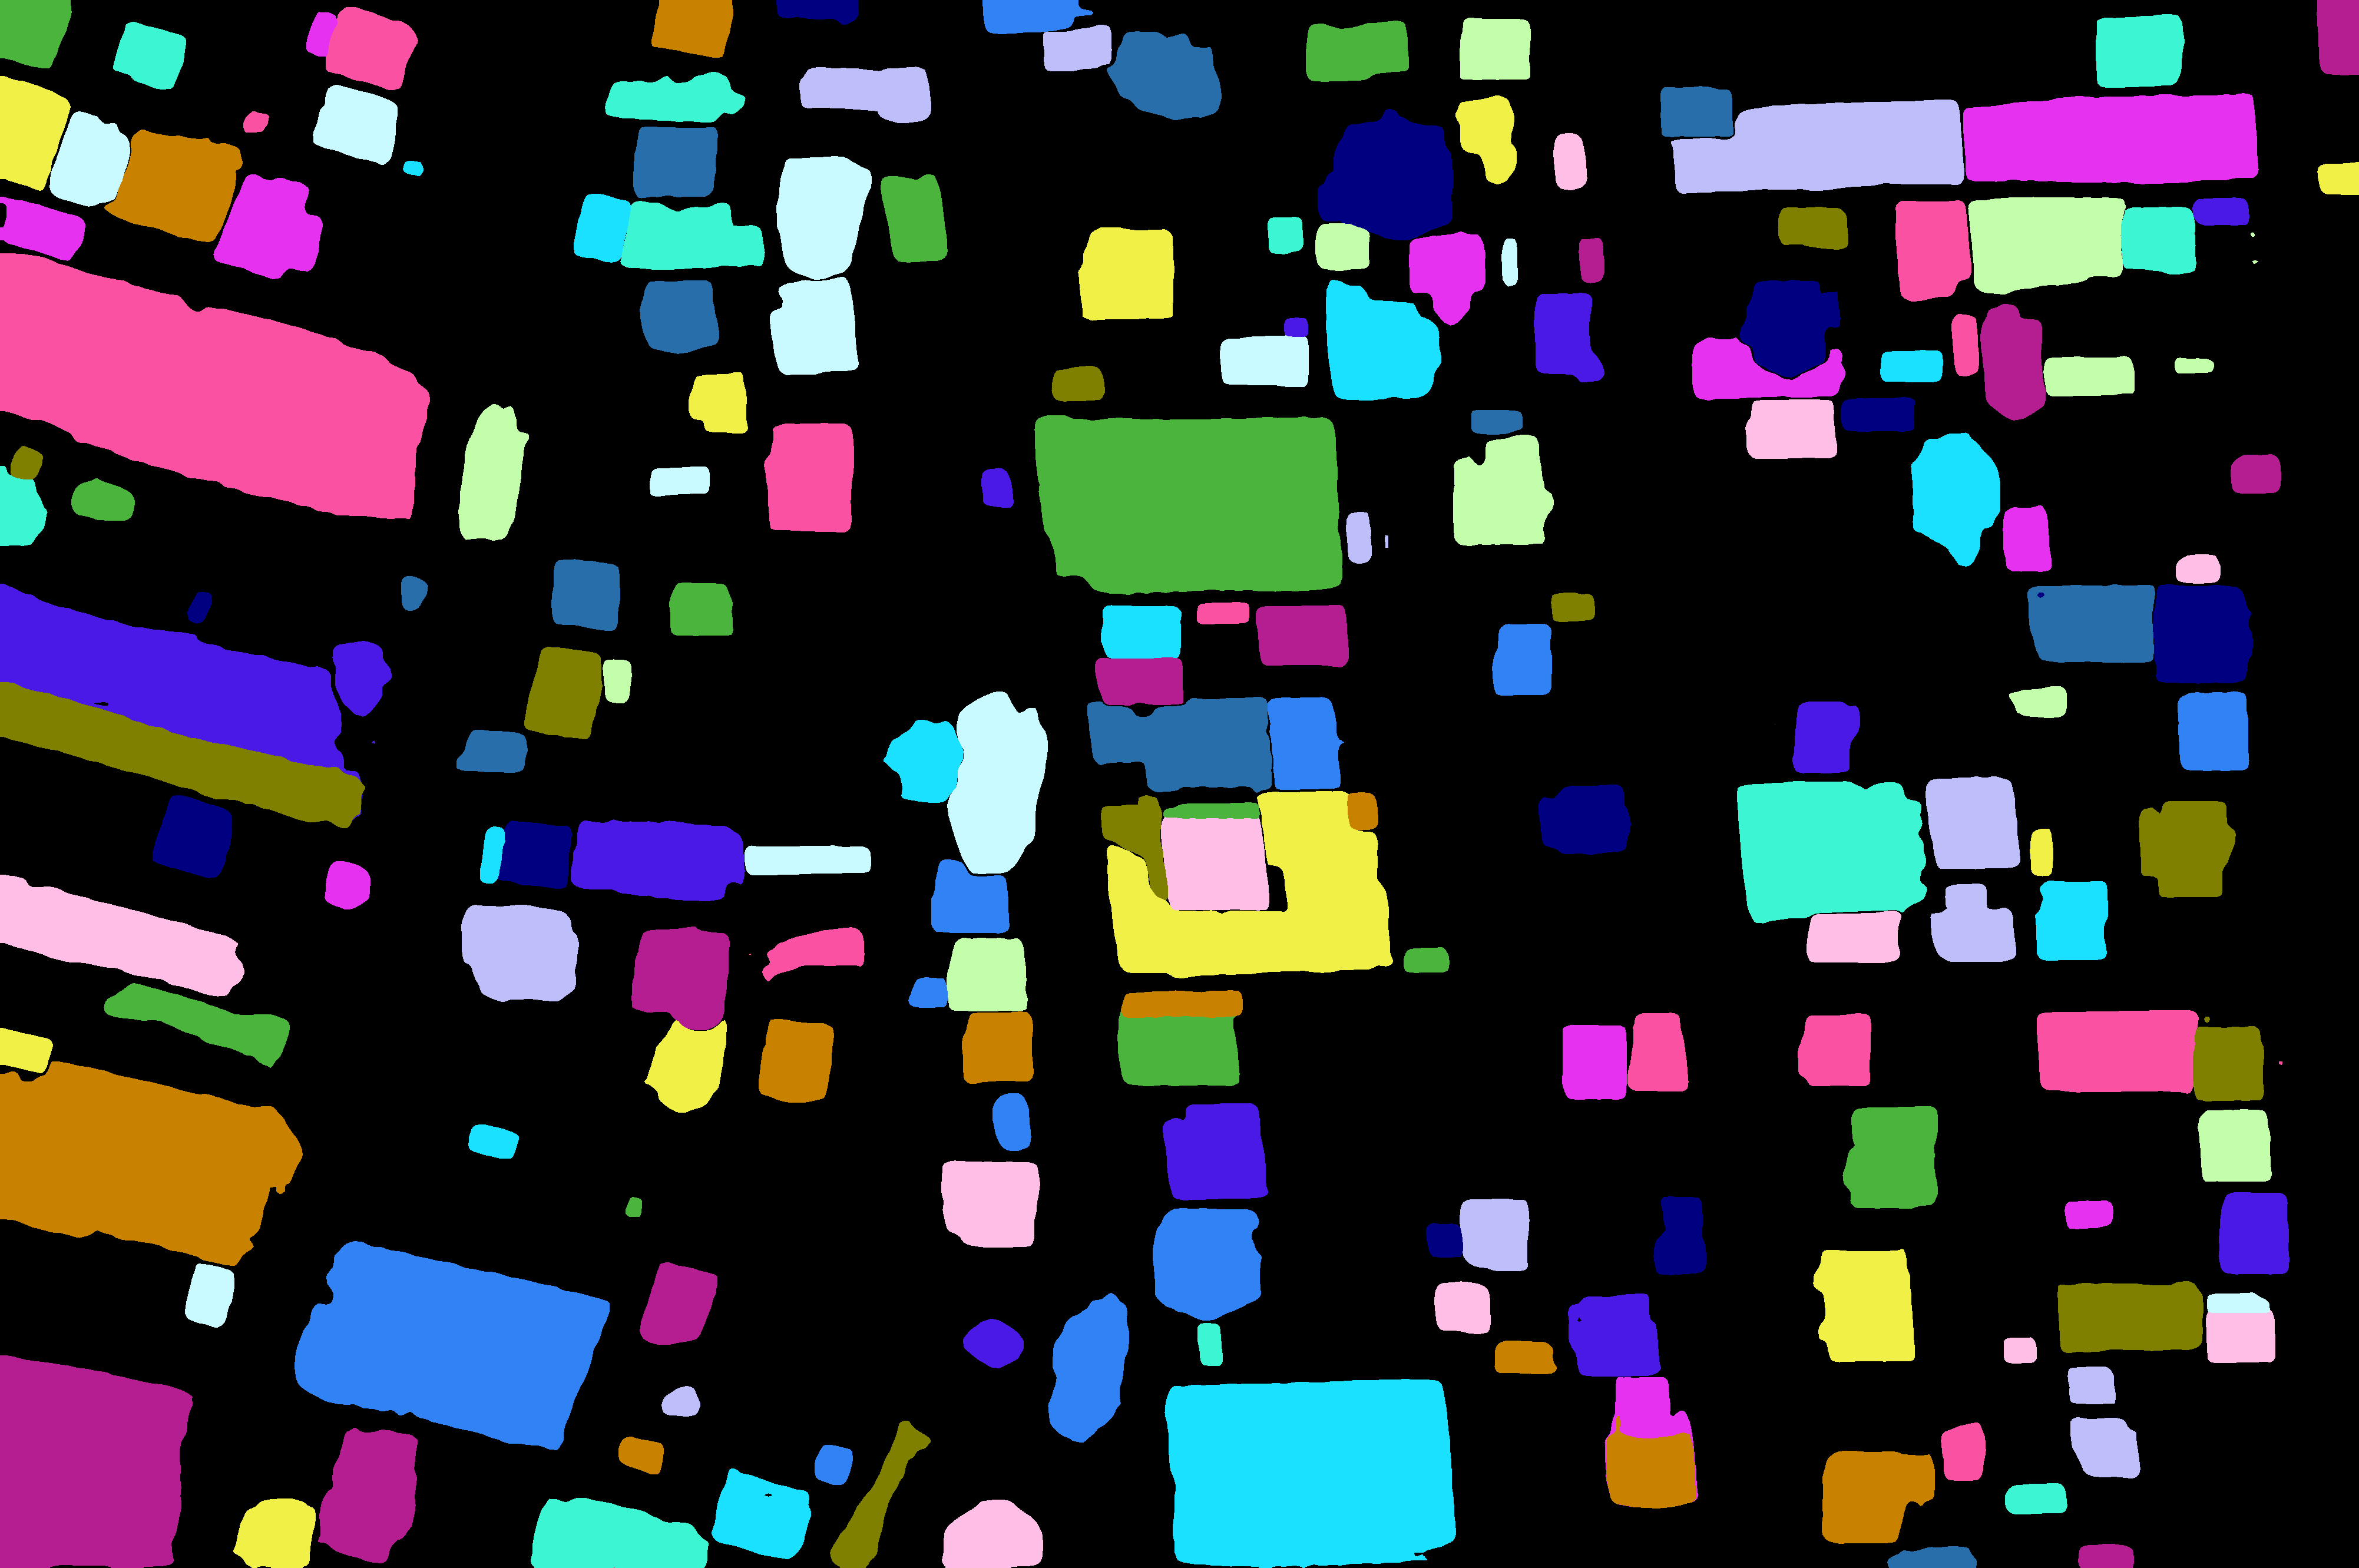

In [47]:
res3

In [48]:
import cv2
import numpy as np

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

from src.constants import CHECKPOINT_PATH
from src.constants import DEVICE
from src.constants import MODEL_TYPE


def get_array_instances_by_image_sam(cam_image):
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

    mask_generator = SamAutomaticMaskGenerator(sam)

    return mask_generator.generate(cam_image)


instances_array = get_array_instances_by_image_sam(cv2.imread('images_cams/images/00000000.jpg'))

In [49]:
np.savez_compressed('0000002.npz', masks=instances_array)

data = np.load('0000002.npz', allow_pickle=True)
print(data.f.masks[0])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 145485, 'bbox': [1756, 705, 522, 304], 'predicted_iou': 1.0001087188720703, 'point_coords': [[1814.765625, 956.65625]], 'stability_score': 0.9749448895454407, 'crop_box': [0, 0, 4005, 2662]}


In [53]:
(instances_array[0]['segmentation'] == data.f.masks[0]['segmentation']).all()

True